In [1]:
import json
import math
import networkx as nx
import numpy as np
from metrics import *
import tensorflow as tf

print(tf.version.VERSION)

2.11.0


In [2]:
#Autoreloads modules that have changed like metrics.py
%load_ext autoreload
%autoreload 2

#Import graph

In [3]:
multigraph = nx.read_graphml('../data/planetoid_split/pubmed.graphml')
print(type(multigraph))

<class 'networkx.classes.graph.Graph'>


In [4]:
G = multigraph

In [5]:
print(list(G.nodes(data=True))[1])

('1', {'w.0': 0.0, 'w.1': 0.0, 'w.2': 0.0, 'w.3': 0.0, 'w.4': 0.0, 'w.5': 0.0, 'w.6': 0.0, 'w.7': 0.01643410325050354, 'w.8': 0.0, 'w.9': 0.0, 'w.10': 0.0, 'w.11': 0.0, 'w.12': 0.0, 'w.13': 0.0, 'w.14': 0.0, 'w.15': 0.0, 'w.16': 0.03209744766354561, 'w.17': 0.0, 'w.18': 0.022160468623042107, 'w.19': 0.0, 'w.20': 0.0, 'w.21': 0.0, 'w.22': 0.027846381068229675, 'w.23': 0.0, 'w.24': 0.0, 'w.25': 0.0, 'w.26': 0.0, 'w.27': 0.023517824709415436, 'w.28': 0.0, 'w.29': 0.0, 'w.30': 0.0, 'w.31': 0.0, 'w.32': 0.0, 'w.33': 0.0, 'w.34': 0.0, 'w.35': 0.0, 'w.36': 0.014730953611433506, 'w.37': 0.0, 'w.38': 0.0, 'w.39': 0.0, 'w.40': 0.0, 'w.41': 0.023626744747161865, 'w.42': 0.0, 'w.43': 0.0, 'w.44': 0.0, 'w.45': 0.0, 'w.46': 0.0, 'w.47': 0.02032988704741001, 'w.48': 0.0, 'w.49': 0.01064450852572918, 'w.50': 0.0, 'w.51': 0.0, 'w.52': 0.0, 'w.53': 0.030394691973924637, 'w.54': 0.0, 'w.55': 0.0, 'w.56': 0.018283119425177574, 'w.57': 0.0, 'w.58': 0.0, 'w.59': 0.0, 'w.60': 0.0, 'w.61': 0.0, 'w.62': 0.0, '

In [6]:
wds = 'class_label'

In [7]:
from collections import Counter

node_labels_set = set()
index = 0
node_labels = {}

for _, node_attrs in list(G.nodes(data=True)):
    node_labels_set.add(node_attrs[wds])

for label in node_labels_set:
    node_labels[label] =  index
    index +=1

typesn = []
for node in G.nodes:
  typesn.append(G.nodes[node][wds])
  G.nodes[node][wds]=node_labels[G.nodes[node][wds]]

Counter(typesn)

Counter({'3': 7739, '1': 4103, '2': 7875})

In [8]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
# torch.cuda.is_available()

In [9]:
node_attributes = list(G.nodes['0'].keys())

In [10]:
grafo = dgl.from_networkx(G,node_attrs=node_attributes)

print(grafo.ndata)

{'w.0': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0511, 0.0000]), 'w.1': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0260, 0.0000]), 'w.2': tensor([0.0000, 0.0000, 0.0147,  ..., 0.0000, 0.0000, 0.0000]), 'w.3': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'w.4': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0496, 0.0000, 0.0000]), 'w.5': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'w.6': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'w.7': tensor([0.0050, 0.0164, 0.0292,  ..., 0.0000, 0.0053, 0.0065]), 'w.8': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'w.9': tensor([0., 0., 0.,  ..., 0., 0., 0.]), 'w.10': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0694]), 'w.11': tensor([0.0480, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), 'w.12': tensor([0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0230, 0.0000]), 'w.13': tensor([0.0130, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]), 'w.14': tensor([0.0172, 0.0000, 0.0000,  ..., 0.0317, 0.0000, 0.0000]), 'w.15': tensor([0., 0., 0.,  ..., 0., 0., 0.]), '

In [11]:
import dgl
from dgl.data import DGLDataset
import torch
import os

class CoraDatasetM(DGLDataset):
    def __init__(self):
        super().__init__(name='coradataset')

    def process(self):
        graph_copy = dgl.from_networkx(G,node_attrs=node_attributes)
        self.graph = dgl.from_networkx(G)

        self.graph.ndata['feat']= graph_copy.ndata['w.0'].reshape(1, -1).T
        for i in node_attributes:
            if 'w.' in i and i != 'w.0':
                tessorTuple = (self.graph.ndata['feat'],graph_copy.ndata[i].reshape(1, -1).T)
                self.graph.ndata['feat']= torch.cat(tessorTuple,1)
        self.graph.ndata['label'] = graph_copy.ndata[wds]

        # If your dataset is a node classification dataset, you will need to assign
        # masks indicating whether a node belongs to training, validation, and test set.
        # n_nodes = self.graph.ndata['label'].shape[0]
        # n_train = int(n_nodes * 0.6)
        # n_val = int(n_nodes * 0.2)
        # train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        # val_mask = torch.zeros(n_nodes, dtype=torch.bool)
        # test_mask = torch.zeros(n_nodes, dtype=torch.bool)
        # train_mask[:n_train] = True
        # val_mask[n_train:n_train + n_val] = True
        # test_mask[n_train + n_val:] = True

        self.graph.ndata['train_mask'] = graph_copy.ndata['train_mask.0']
        self.graph.ndata['val_mask'] = graph_copy.ndata['validation_mask.0']
        self.graph.ndata['test_mask'] = graph_copy.ndata['test_mask.0']

    def num_classes(self):
        return len(Counter(self.graph.ndata['label'].numpy()))

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

dataset = CoraDatasetM()
g = dataset[0]
g = dgl.add_self_loop(g)
# g = g.to('cuda')

print(g)

Graph(num_nodes=19717, num_edges=108365,
      ndata_schemes={'feat': Scheme(shape=(500,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})


In [12]:
print(g)
print(g.ndata)
print(g.edata)
print(g.ndata['feat'].shape)
print(dataset.num_classes())

Graph(num_nodes=19717, num_edges=108365,
      ndata_schemes={'feat': Scheme(shape=(500,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'train_mask': Scheme(shape=(), dtype=torch.bool), 'val_mask': Scheme(shape=(), dtype=torch.bool), 'test_mask': Scheme(shape=(), dtype=torch.bool)}
      edata_schemes={})
{'feat': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0147,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0511, 0.0260, 0.0000,  ..., 0.0375, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3617]]), 'label': tensor([2, 2, 0,  ..., 0, 1, 2]), 'train_mask': tensor([ True,  True,  True,  ..., False, False, False]), 'val_mask': tensor([False, False, False,  ..., False, False, False]), 'test_mask': tensor([False, False, False,  ..., False, False, False])}
{}
tor

In [13]:
from dgl.nn.pytorch import GraphConv
from models.gat.pygat import GAT
from models.gcn.pygcn import GCN
from models.graphsage.pygraphsage import SAGE
import tensorflow as tf
from torchsummary import summary

# pytorch gcn model
# model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes())

# # pytorch gat model
# model = GAT(g.ndata['feat'].shape[1], 8, dataset.num_classes(), heads=[8, 1])

# pytorch sage model
model = SAGE(g.ndata['feat'].shape[1], 256, dataset.num_classes())

# tensorflow/keras GCN model not working :(

# in_feats = g.ndata['feat'].shape[1]
# n_hidden = 16
# n_classes = dataset.num_classes()
# n_layers = 0
# dropout = hp.dropout
# model = GCN(
#     g,
#     in_feats,
#     n_hidden,
#     n_classes,
#     n_layers,
#     tf.nn.relu,
#     dropout,
# )
# summary(model, input_size=(1, 1433))

In [14]:
def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features.float())
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

def train(g, features, labels, masks, model):
    # define train/val samples, loss function and optimizer
    train_mask = masks[0]
    val_mask = masks[1]
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)
    best_val_loss = math.inf
    patience = model.metrics.patience

    # training loop
    for epoch in range(200):
        model.train()
        logits = model(g, features.float())
        loss = loss_fcn(logits[train_mask], labels[train_mask])
        val_loss = loss_fcn(logits[val_mask], labels[val_mask])
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = model.metrics.patience
        else:
            patience -= 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = evaluate(g, features, labels, val_mask, model)
        print(
            "Epoch {:05d} | Loss {:.4f} | Accuracy {:.4f} ".format(
                epoch, loss.item(), acc
            )
        )

        # if patience == 0:
        #     break

features = g.ndata['feat']
labels = g.ndata['label']
masks = g.ndata['train_mask'], g.ndata['val_mask'], g.ndata['test_mask']

train(g, features, labels, masks, model)

Epoch 00000 | Loss 1.0941 | Accuracy 0.7060 
Epoch 00001 | Loss 0.7783 | Accuracy 0.6700 
Epoch 00002 | Loss 0.4439 | Accuracy 0.7200 
Epoch 00003 | Loss 0.2706 | Accuracy 0.7140 
Epoch 00004 | Loss 0.1171 | Accuracy 0.6880 
Epoch 00005 | Loss 0.0774 | Accuracy 0.7500 
Epoch 00006 | Loss 0.0104 | Accuracy 0.7880 
Epoch 00007 | Loss 0.0043 | Accuracy 0.7760 
Epoch 00008 | Loss 0.0017 | Accuracy 0.7740 
Epoch 00009 | Loss 0.0069 | Accuracy 0.7760 
Epoch 00010 | Loss 0.0030 | Accuracy 0.7780 
Epoch 00011 | Loss 0.0020 | Accuracy 0.7820 
Epoch 00012 | Loss 0.0012 | Accuracy 0.7820 
Epoch 00013 | Loss 0.0000 | Accuracy 0.7760 
Epoch 00014 | Loss 0.0000 | Accuracy 0.7780 
Epoch 00015 | Loss 0.0000 | Accuracy 0.7800 
Epoch 00016 | Loss 0.0002 | Accuracy 0.7740 
Epoch 00017 | Loss 0.0002 | Accuracy 0.7700 
Epoch 00018 | Loss 0.0000 | Accuracy 0.7700 
Epoch 00019 | Loss 0.0000 | Accuracy 0.7640 
Epoch 00020 | Loss 0.0001 | Accuracy 0.7660 
Epoch 00021 | Loss 0.0000 | Accuracy 0.7680 
Epoch 0002

In [15]:
features = g.ndata['feat']
labels = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

import time

start = time.time()

logits = model(g, features.float())
# the training phase left the gradient in the tensor with gat, so we need to convert it to a tensor with gradient set to None, otherwise
# trying to print the confusion matrix is gonna get errors
logits = torch.tensor(logits)

end = time.time()
print(end - start)

train_x = features[train_mask]
val_x = features[val_mask]
test_x = features[test_mask]

train_logits = logits[train_mask]
val_logits = logits[val_mask]
test_logits = logits[test_mask]
train_labels = labels[train_mask]
val_labels = labels[val_mask]
test_labels = labels[test_mask]

print(logits.shape)
print(train_logits.shape)
print(val_logits.shape)
print(test_logits.shape)

0.22322416305541992
torch.Size([19717, 3])
torch.Size([60, 3])
torch.Size([500, 3])
torch.Size([1000, 3])


C:\Users\Leonardo\AppData\Local\Temp\ipykernel_18740\2962514485.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  logits = torch.tensor(logits)


In [16]:
print(logits, logits.grad_fn, type(logits))


one_hot_y_train = F.one_hot(train_labels)
one_hot_y_val = F.one_hot(val_labels)
one_hot_y_test = F.one_hot(test_labels)


tensor([[-2.5360, -2.7569,  4.2344],
        [-2.0480, -3.2187,  4.2669],
        [ 4.1537, -2.5793, -1.6069],
        ...,
        [-2.7375, -0.5481,  2.2687],
        [-3.9047,  3.9065, -1.2535],
        [-1.4113, -2.0175,  2.5473]]) None <class 'torch.Tensor'>



Test metrics:
Accuracy: 1.0000
Precision macro: 1.0000
Recall macro: 1.0000
F1 Score macro: 1.0000
AUC-ROC macro,ovr: 1.0000


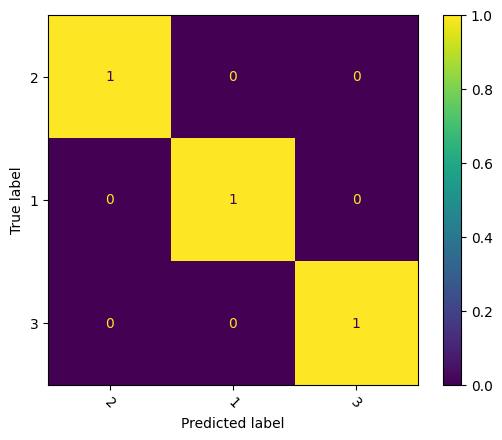

Saving metrics to saved\pubmed\dgl_GCN_example1_2023-01-06_17-12-46.json

Test metrics:
Accuracy: 0.7860
Precision macro: 0.7871
Recall macro: 0.7994
F1 Score macro: 0.7912
AUC-ROC macro,ovr: 0.9167


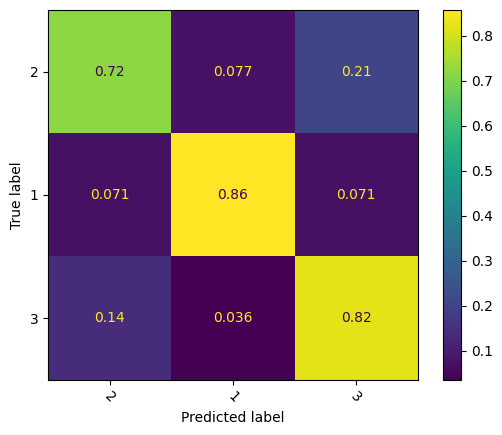

Saving metrics to saved\pubmed\dgl_GCN_example1_2023-01-06_17-12-46.json

Test metrics:
Accuracy: 0.7760
Precision macro: 0.7683
Recall macro: 0.7773
F1 Score macro: 0.7723
AUC-ROC macro,ovr: 0.9118


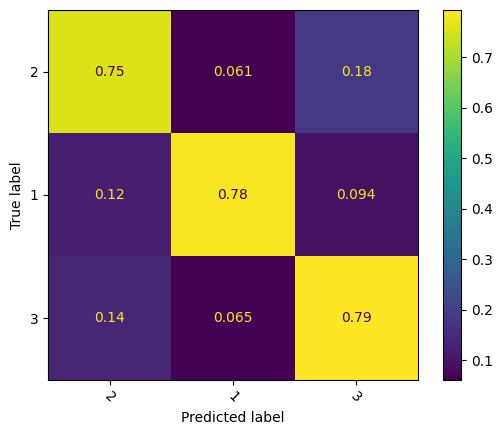

Saving metrics to saved\pubmed\dgl_GCN_example1_2023-01-06_17-12-47.json


In [17]:
from metrics import Datasets, Frameworks

display_and_save(framework=Frameworks.DGL,
                 dataset_name=Datasets.PUBMED,
                 model_name='GCN_example1',
                 predictions=train_logits,#Output of the model
                 y=one_hot_y_train,#True labels, one hot encoded
                 class_names=node_labels,
                 exec_ms=1050)

display_and_save(framework=Frameworks.DGL,
                 dataset_name=Datasets.PUBMED,
                 model_name='GCN_example1',
                 predictions=val_logits,#Output of the model
                 y=one_hot_y_val,#True labels, one hot encoded
                 class_names=node_labels,
                 exec_ms=1050)

display_and_save(framework=Frameworks.DGL,
                 dataset_name=Datasets.PUBMED,
                 model_name='GCN_example1',
                 predictions=test_logits,#Output of the model
                 y=one_hot_y_test,#True labels, one hot encoded
                 class_names=node_labels,
                 exec_ms=1050)